In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import itertools

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm

In [72]:
df = pd.read_csv('data_inflasi.csv', sep=';')
df

,Bulan,Inflasi
0,2011-01,0.0702
1,2011-02,0.0684
2,2011-03,0.0665
3,2011-04,0.0616
4,2011-05,0.0598
...,...,...
151,2023-08,0.0327
152,2023-09,0.0228
153,2023-10,0.0256
154,2023-11,0.0286


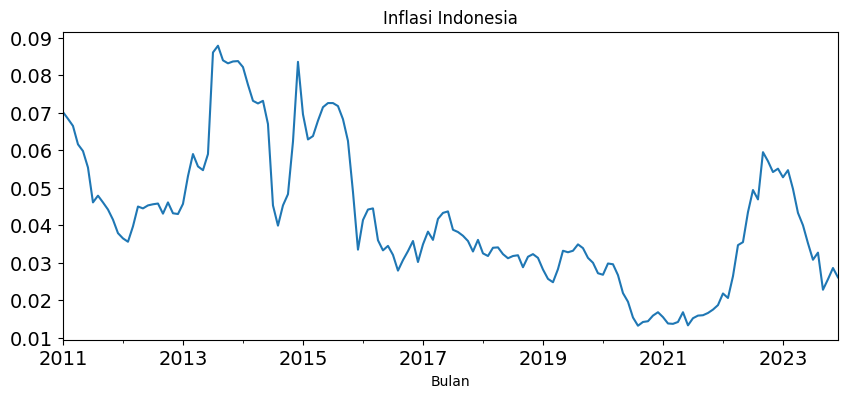

In [ ]:


datetimeindex = pd.to_datetime([f'{m_y.split("-")[0]}-{m_y.split("-")[1]}-01' for m_y in df['Bulan']])

df['Bulan'] = datetimeindex

df = df.set_index('Bulan')

y = df['Inflasi'].resample('MS').mean()

y.plot(figsize=(10, 4), title='Inflasi Indonesia', fontsize=14)
plt.show()

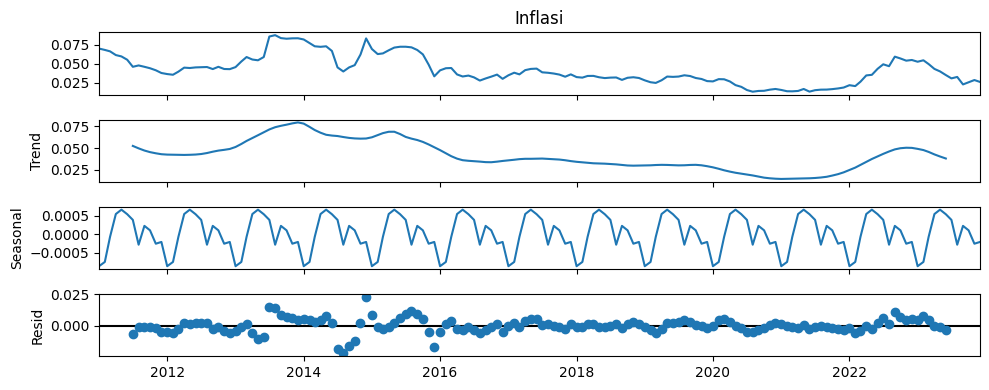

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 4

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()

In [12]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [41]:
# 80% training, 20% testing
train_size = int(len(y) * 0.8)
train = y[:train_size]
test = y[train_size:]

print(f"Jumlah data training: {len(train)}")
print(f"Jumlah data testing: {len(test)}")

Jumlah data training: 124
Jumlah data testing: 32


In [42]:
model = pm.ARIMA(order=(1, 0, 1), 
                 seasonal_order=(0, 0, 0, 12), 
                 seasonal=True, m=12)
results = model.fit(train)

print(results.summary())

# mod = sm.tsa.statespace.SARIMAX(y,
#                                 order=(1, 0, 1),
#                                 seasonal_order=(0, 0, 0, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)

# results = mod.fit()

# print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  124
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 476.482
Date:                Wed, 28 May 2025   AIC                           -944.963
Time:                        00:37:10   BIC                           -933.682
Sample:                    01-01-2011   HQIC                          -940.381
                         - 04-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.003      0.899      0.369      -0.003       0.008
ar.L1          0.9459      0.049     19.308      0.000       0.850       1.042
ma.L1          0.3357      0.091      3.694      0.0

c:\Users\YOGA\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


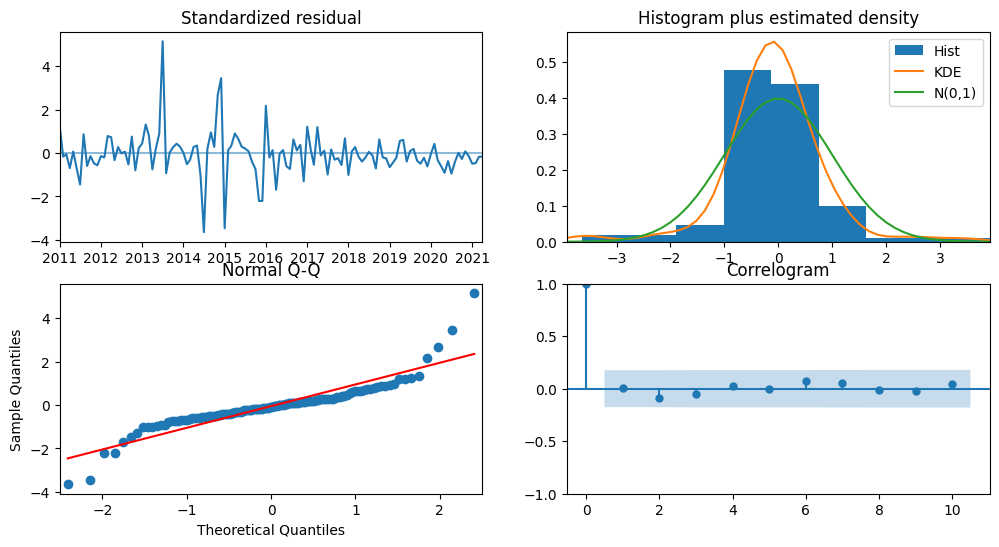

In [43]:
results.plot_diagnostics(figsize=(12, 6))
plt.show()

In [80]:
n_periods = len(test)
forecast = results.predict(n_periods=32)
forecast_index = test.index

In [81]:
forecast_series = pd.Series(forecast, index=forecast_index)

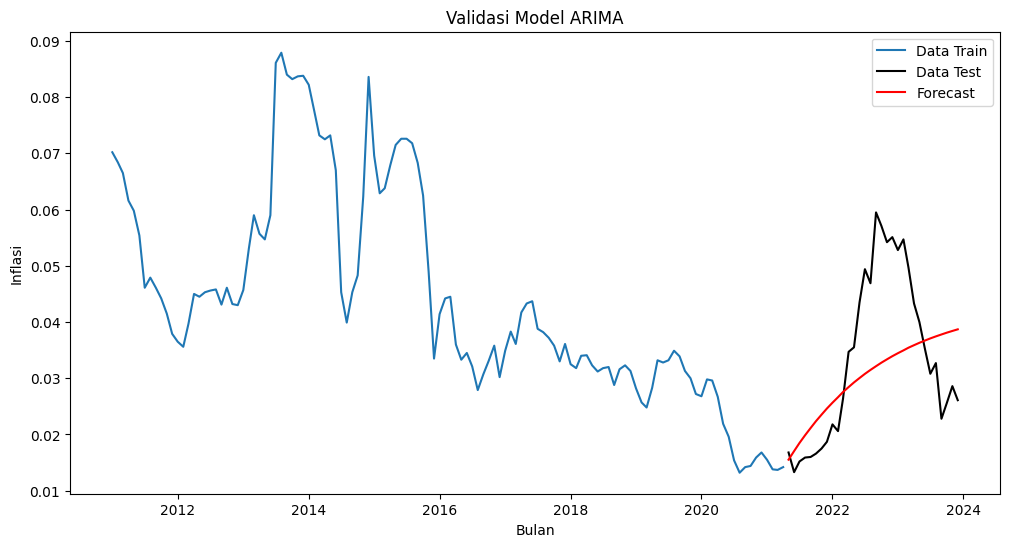

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Data Train')
plt.plot(test.index, test, label='Data Test', color='black')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')
plt.title('Validasi Model ARIMA')
plt.xlabel('Bulan')
plt.ylabel('Inflasi')
plt.legend()
plt.show()

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(test, forecast_series))
mae = mean_absolute_error(test, forecast_series)
mape = np.mean(np.abs((test - forecast_series) / test)) * 100

print(f'RMSE: {rmse:.4f}')
print(f'MAE:  {mae:.4f}')
print(f'MAPE: {mape:.2f}%')

RMSE: 0.0125
MAE:  0.0102
MAPE: 29.11%


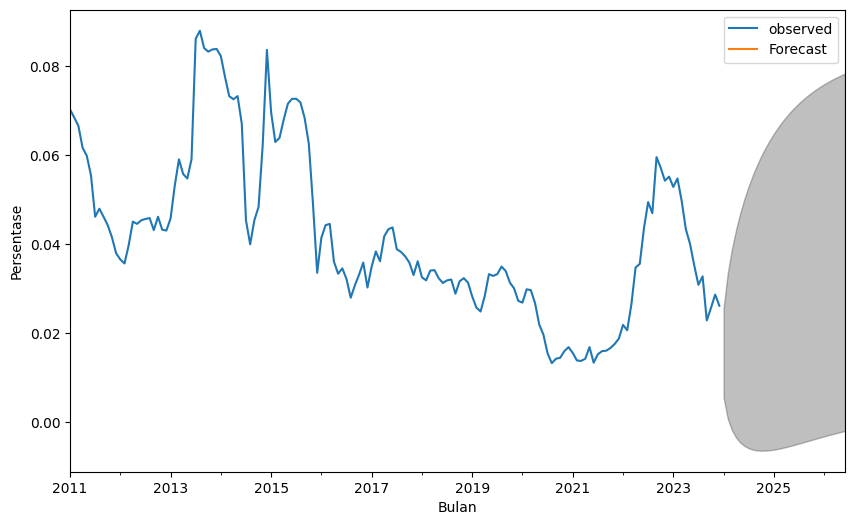

In [86]:
# Forecast using pmdarima ARIMA
n_periods = 32
forecast_pmdarima = results.predict(n_periods=n_periods)
forecast_index_pmdarima = conf_int_df_pmdarima.index

# Plot observed and forecast
ax = y.plot(label='observed', figsize=(10, 6))
pd.Series(forecast_pmdarima, index=forecast_index_pmdarima).plot(ax=ax, label='Forecast')

# Plot confidence interval
ax.fill_between(
    conf_int_df_pmdarima.index,
    conf_int_df_pmdarima['lower'],
    conf_int_df_pmdarima['upper'],
    color='k', alpha=.25
)
ax.set_xlabel('Bulan')
ax.set_ylabel('Persentase')

plt.legend()
plt.show()

In [87]:
print(pd.Series(forecast_pmdarima, index=forecast_index_pmdarima))

2024-01-01   NaN
2024-02-01   NaN
2024-03-01   NaN
2024-04-01   NaN
2024-05-01   NaN
2024-06-01   NaN
2024-07-01   NaN
2024-08-01   NaN
2024-09-01   NaN
2024-10-01   NaN
2024-11-01   NaN
2024-12-01   NaN
2025-01-01   NaN
2025-02-01   NaN
2025-03-01   NaN
2025-04-01   NaN
2025-05-01   NaN
2025-06-01   NaN
2025-07-01   NaN
2025-08-01   NaN
2025-09-01   NaN
2025-10-01   NaN
2025-11-01   NaN
2025-12-01   NaN
2026-01-01   NaN
2026-02-01   NaN
2026-03-01   NaN
2026-04-01   NaN
2026-05-01   NaN
2026-06-01   NaN
Freq: MS, dtype: float64


In [35]:
# Use forecast and the actual values for the forecast period
y_forecasted = forecast
y_truth = y[forecast_index]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

KeyError: "None of [DatetimeIndex(['2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',\n               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',\n               '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01'],\n              dtype='datetime64[ns]', freq='MS')] are in the [index]"

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2021-01-01':]

# mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()


ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Bulan')
ax.set_ylabel('Persentase')


plt.legend()
plt.show()

In [ ]:
print(pred_ci)